In [1]:
from importlib import reload
import qubic.job_manager_jpm as _jm
from matplotlib import pyplot as plt
import chipcalibration.rabi_experiments as _rabi
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as _cfg
import qubic.rpc_client as _rc
import numpy as np

In [2]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = _cfg.load_configs(qchipname, qchip_file='qubitcfg.json')

In [3]:
runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip)

In [4]:
register = ['Q2', 'Q3']
target_amplitude = qchip.gates['Q2X90'].cfg_dict[0]['amp']
pulse_width_interval = np.linspace(1e-9, 100e-9, 10)

In [5]:
gmm_rabi = _rabi.GMMRabi(register, target_amplitude, pulse_width_interval, 
                       channel_configs=channel_config)

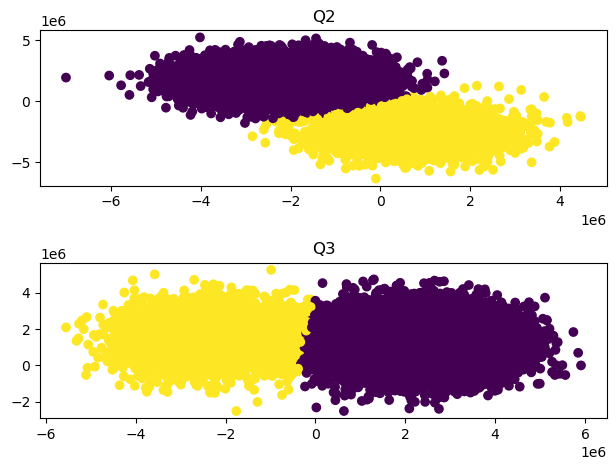

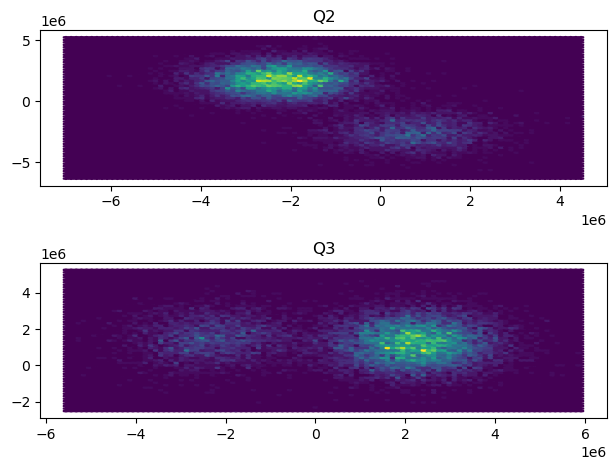

In [6]:
gmm_rabi.run_and_report(jm, 1000, qchip)

In [7]:
def cr_sweep_circuit(control_qubit, target_qubit, pulse_width, amp_control, amp_target):
    circuits = []
    for ctrl_state in [0, 1]:
        for axis in ('X', 'Y', 'Z'):
            circuit = [{'name': 'delay', 't': 400.e-6}]
            if ctrl_state == 1:
                circuit.append({'name': 'X90', 'qubit':[control_qubit]})
                circuit.append({'name': 'X90', 'qubit':[control_qubit]})
            circuit.append({'name': 'CR_crosstalk', 'qubit': [control_qubit, target_qubit],
                            'modi':{(0, 'twidth'): pulse_width, 
                                    (1, 'twidth'): pulse_width, 
                                    (0, 'amp'): amp_control,
                                    (1, 'amp'): amp_target}})
            circuit.append({'name': 'X90', 'qubit': [control_qubit]})
            circuit.append({'name': 'X90', 'qubit': [control_qubit]})
            circuit.append({'name': 'CR_crosstalk', 'qubit': [control_qubit, target_qubit],
                            'modi':{(0, 'twidth'): pulse_width, 
                                    (1, 'twidth'): pulse_width, 
                                    (0, 'amp'): amp_control,
                                    (1, 'amp'): amp_target,
                                    (0, 'pcarrier'): np.pi,
                                    (1, 'pcarrier'): np.pi}})
            circuit.append({'name': 'X90', 'qubit': [control_qubit]})
            circuit.append({'name': 'X90', 'qubit': [control_qubit]})
            if axis == 'X':
                circuit.append({'name': 'Y-90', 'qubit': [target_qubit]})
                
            elif axis == 'Y':
                circuit.append({'name': 'X90', 'qubit': [target_qubit]})
                
            circuit.append({'name': 'read', 'qubit': [control_qubit]})
            circuit.append({'name': 'read', 'qubit': [target_qubit]})
            
            circuits.append(circuit)
    
    return circuits

In [8]:
control = 'Q3'
target = 'Q2'

In [9]:
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip, gmm_rabi.gmm_manager)

In [10]:
half_widths = np.linspace(10.e-9, 300.e-9, 20)

In [11]:
r = []
tomo_list = []
#shot order: 0: ctrl0, x; 1: ctrl0, y; 2: ctrl0, z; 3: ctrl1, x; 4: ctrl1, y; 5: ctrl1, z
for width in half_widths:
    circuits = cr_sweep_circuit(control, target, width, 0.3, 0.003)
    shotsout = jm.build_and_run_circuits(circuits, 1000, outputs=['shots'])['shots']
    target_avg = np.average(shotsout[target], axis=1)
    tomo_list.append(target_avg)

In [13]:
tomo_arr = np.asarray(tomo_list)
tomo_arr = 1-tomo_arr*2

In [14]:
tomo_arr.shape
r_sum = 0.5*np.sqrt((tomo_arr[:,3] + tomo_arr[:,0])**2 +
            + (tomo_arr[:,4] + tomo_arr[:,1])**2 + (tomo_arr[:,5] + tomo_arr[:,2])**2)
r = 0.5*np.sqrt((tomo_arr[:,3] - tomo_arr[:,0])**2 +
            + (tomo_arr[:,4] - tomo_arr[:,1])**2 + (tomo_arr[:,5] - tomo_arr[:,2])**2)
r_td = 0.5*(abs(tomo_arr[:,3] - tomo_arr[:,0]) +
            + abs(tomo_arr[:,4] - tomo_arr[:,1]) + abs(tomo_arr[:,5] - tomo_arr[:,2]))

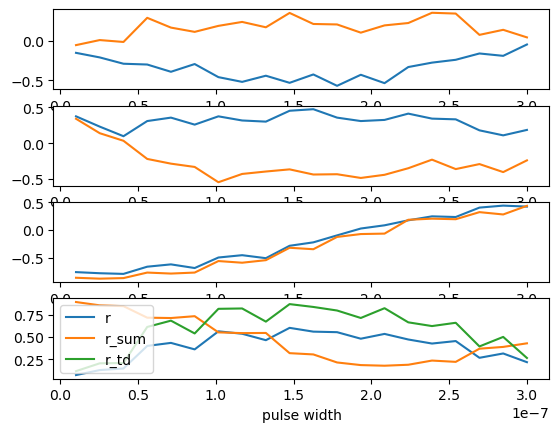

In [15]:
fig, axs = plt.subplots(4,1)
axs[0].plot(half_widths, tomo_arr[:,0], label='x0')
axs[1].plot(half_widths, tomo_arr[:,1], label='y0')
axs[2].plot(half_widths, tomo_arr[:,2], label='z0')
axs[0].plot(half_widths, tomo_arr[:,3], label='x1')
axs[1].plot(half_widths, tomo_arr[:,4], label='y1')
axs[2].plot(half_widths, tomo_arr[:,5], label='z1')
axs[3].plot(half_widths, r, label='r')
axs[3].plot(half_widths, r_sum, label='r_sum')
axs[3].plot(half_widths, r_td, label='r_td')


plt.xlabel('pulse width')
plt.legend()